In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox

# 1. Нестационарный график

**В качестве нестационарного графика возьму график авиаперевозок пассажиров по месяцам**

In [2]:
path = 'C:\\Users\\79111\\Notebooks\\11. Временные ряды\\1._Лекция_tsml\\Series\\'
series = pd.read_csv(path+"international-airline-passengers.csv")["Count"]

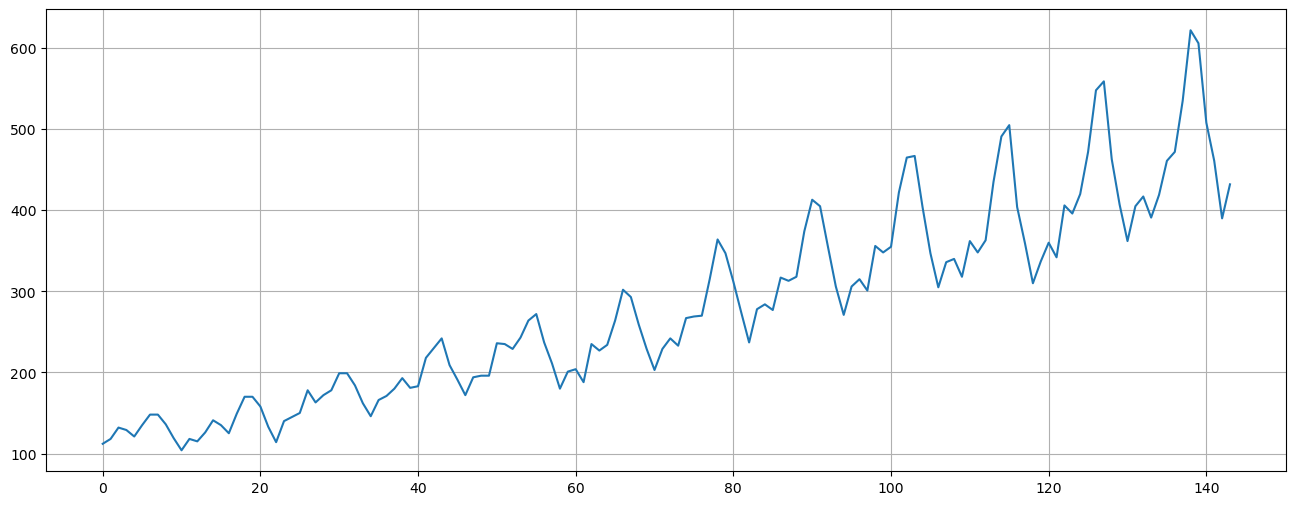

In [3]:
plt.figure(figsize=(16,6))
plt.plot(series)
plt.grid()

**Поскольку в графике присутствует сезонность и тренд, то я буду использовать метод Хольта-Винтерса для получения хорошего приближения и возможности строить прогноз на большое число шагов вперед**

In [4]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[j*slen:j*slen+slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[j*slen+i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

In [5]:
def triple_ema_with_preds(series, slen, alpha, beta, gamma, n_pred=None):
    result = [series[0]]
    level = [series[0]]
    trend = [float(series[slen] - series[0]) / slen**2]
    seasonals = initial_seasonal_components(series, slen)
    
    for n in range(1, len(series)):
        level.append(alpha * (series[n] - seasonals[n%slen]) + (1 - alpha) * (level[-1] + trend[-1]))
        trend.append(beta * (level[-1] - level[-2]) + (1 - beta) * trend[-1])
        seasonals[n%slen] = gamma * (series[n] - level[-1]) + (1 - gamma) * seasonals[n%slen]
        result.append(level[-1] + trend[-1] + seasonals[n%slen])
    
    if not n_pred:
        return pd.Series(result), pd.Series(level), pd.Series(trend)
    
    # forecasting
    for n in range(len(series), len(series)+n_pred):
        m = n - len(series) + 1
        result.append(level[-1] + m*trend[-1] + seasonals[n%slen])
    return result

In [6]:
def plot_tema(alpha, beta, gamma, series, ser_to_plot, slen, n_pred):
    plt.figure(figsize=(16,6))
    plt.plot(ser_to_plot, label='Original')
    tema = triple_ema_with_preds(series, slen, alpha, beta, gamma, n_pred)
    plt.plot(tema, label='TEMA')
    plt.title(f'alpha = {alpha}, beta = {beta}, gamma = {gamma}')
    plt.grid()
    plt.legend();

**Период сезонности в рассматриваемом графике равен 12. Для того, чтобы проверить как работает сглаживание и прогнозирование, просто подставлю пока в параметры `alpha, beta, gamma` значения `0.1, 0.2, 0.4`. Буду строить прогноз на 24 точки вперед**

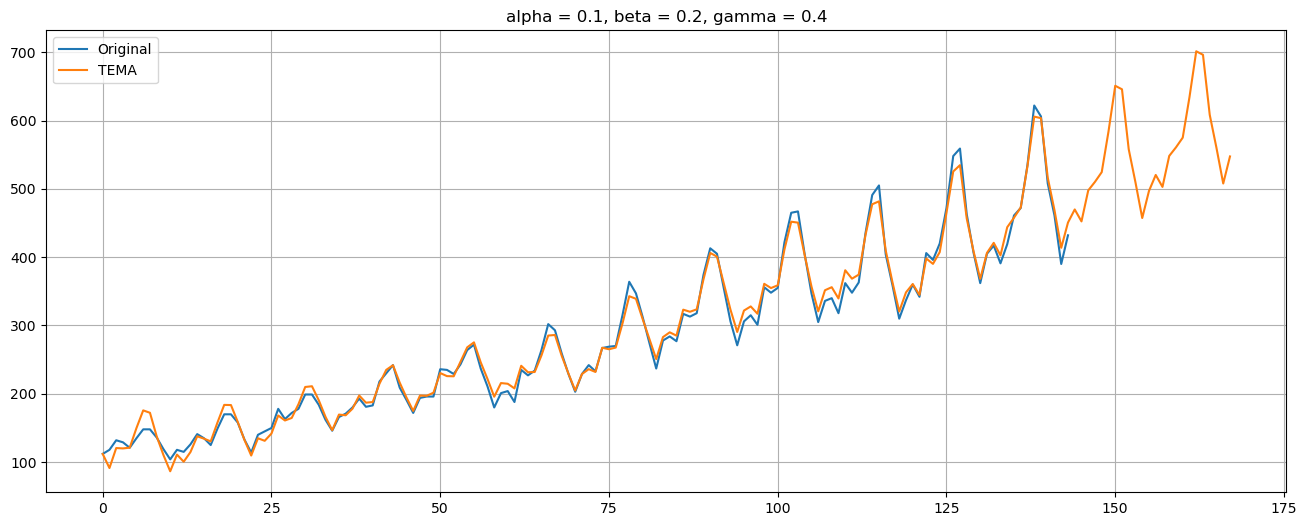

In [7]:
plot_tema(0.1, 0.2, 0.4, series, series, 12, 24)

**Для подбора параметров `alpha, beta, gamma`, позволящих строить более точный прогноз воспользуюсь кросс-валидационным подходом**

In [8]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val_tema(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=6)
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        
        result = triple_ema_with_preds(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        errors.append(mean_squared_error(predictions, test_split_ts))
        
    return np.mean(np.array(errors))

**Разделю выборку на обучающую и валидационную, оставив для обучения 10 сезонов, а для валидации 2**

In [9]:
train, val = series[:120], series[120:]

**Теперь для подбора параметров `alpha, beta, gamma` оптимизатор будет минимизировать мою функцию потерь `mse_cross_val_tema`**

MSE: 399.1225576687762


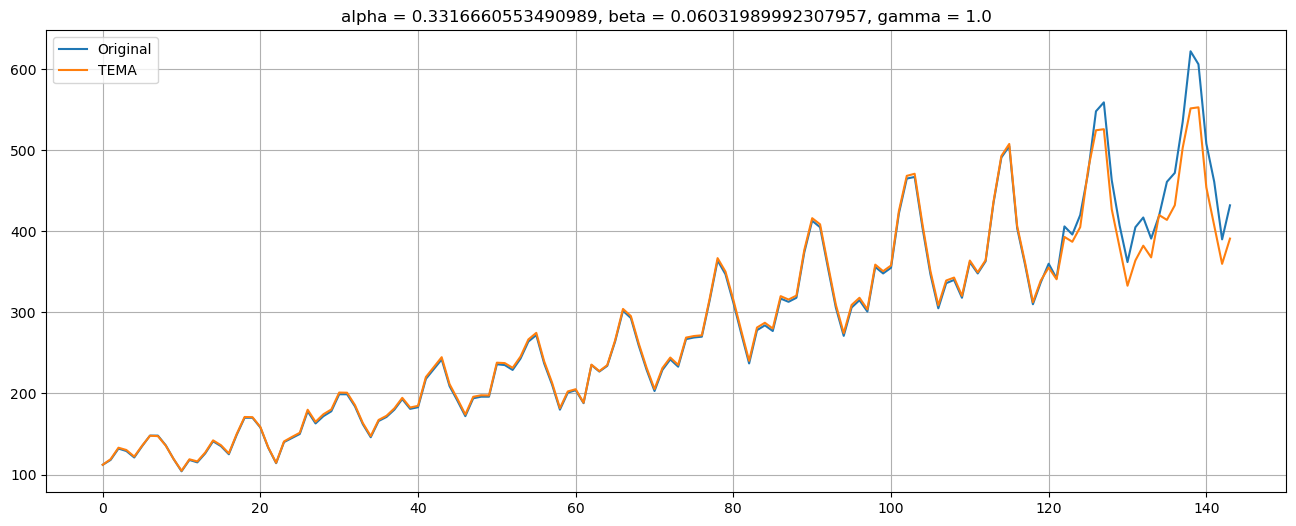

In [10]:
opt = minimize(mse_cross_val_tema, x0=[0,0,0], method='L-BFGS-B', bounds=((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt, series=train, ser_to_plot=series, slen=12, n_pred=len(val))
print('MSE:', opt.fun)

**MSE на обучающей выборке получилось равным 399, что на мой взгляд очень хорошо, и это видно по графику сглаживания, который практически полностью повторяет оригинальный график на его тренировочной части. Но гораздо важнее узнать какая получилась ошибка на валидационной части**

In [11]:
preds_my = triple_ema_with_preds(train, 12, 0.1, 0.2, 0.4, len(val))[-len(val):]
preds_opt = triple_ema_with_preds(train, 12, alpha_opt, beta_opt, gamma_opt, len(val))[-len(val):]

print('MSE с моими параметрами:', mean_squared_error(preds_my, val))
print('MSE после оптимизации:', mean_squared_error(preds_opt, val))

MSE с моими параметрами: 3454.2215312171297
MSE после оптимизации: 1228.0401785971335


Для сравнения я посчитал MSE на предсказаниях с параметрами `alpha, beta, gamma` равными `0.1, 0.2, 0.4`, которые я ранее выставил интуитивно, а также MSE на предсказаниях с оптимизированными параметрами. Оптимизированные параметры уменьшили ошибку почти в три раза с 3454 до 1228. Я считаю, что это хороший результат работы оптимизатора.

При этом надо заметить, что ошибка на валидационной выборке сильно выше, чем на тренировочной (было 399). Это видно и на графике - последние 2 сезона линия предсказанных значений уже не так плотно прилегает к оригинальной линии - предсказываются заниженные значения.

Отмечу также, что на качество работы оптимизатора сильно влияет значение параметра `n_splits` из функции `TimeSeriesSplit`, которая входит в функцию потерь `mse_cross_val_tema`. Значение `n_splits = 6` дало наилучший результат для рассматриваемого временного ряда на валидационной выборке. Я связываю это с тем, что в одном сезоне 12 значений, а 6 является его наибольшим делителем. Пожалуй, если бы было больше данных, то `n_splits = 12` дал бы результат еше лучше.

# 2. Стационарный график

**В качестве стационарного графика буду рассматривать тот же график, но приведенный к стационарности**

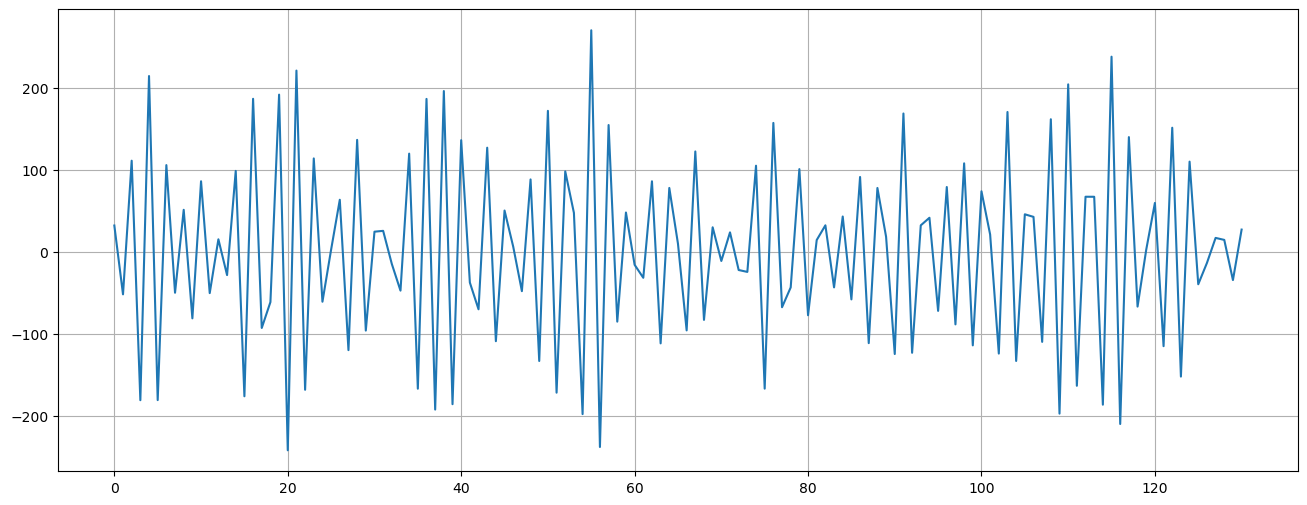

In [12]:
series = boxcox(series, 0)
series = np.diff(series, 1)
series = np.diff(series, 12)
series = pd.Series(series)

plt.figure(figsize=(16,6))
plt.plot(series)
plt.grid()

**В этом ряде уже нет ни тренда ни сезонности, поэтому использовать двойное, или тройное экспоненциальное сглаживание нет смысла. Попробую взять обычное экспоненциальное сглаживание и проделать аналогичную процедуру подбора параметра `alpha` и прогнозирования на 24 точки вперед. При этом я не жду, что качество на отложенной выборке будет хоть сколько-нибудь вменяемым, поскольку этот метод не рассчитан на прогнозирование стационарных временных рядов более чем на одно значение вперед. Предполагаю, что предсказанный график в итоге выродится в прямую линию на уровне нуля**

In [13]:
def ema_with_preds(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[-1])
    if not n_pred:
        return result
    
    predictions = [alpha * series.iloc[-1] + (1 - alpha) * result[-1]]
    
    for i in range(n_pred-1):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        predictions.append(res)
        result.append(res)
    
    return result

In [14]:
def plot_ema(alpha, series, ser_to_plot, n_pred):
    plt.figure(figsize=(16,6))
    plt.plot(ser_to_plot, label='Original')
    ema = ema_with_preds(series, alpha, n_pred)
    plt.plot(ema, label='EMA')
    plt.title(f'alpha = {alpha}')
    plt.grid()
    plt.legend();

**Для того, чтобы проверить как работает сглаживание и прогнозирование, просто подставлю пока в параметр `alpha` значение `0.8`. Буду строить прогноз на 24 точки вперед**

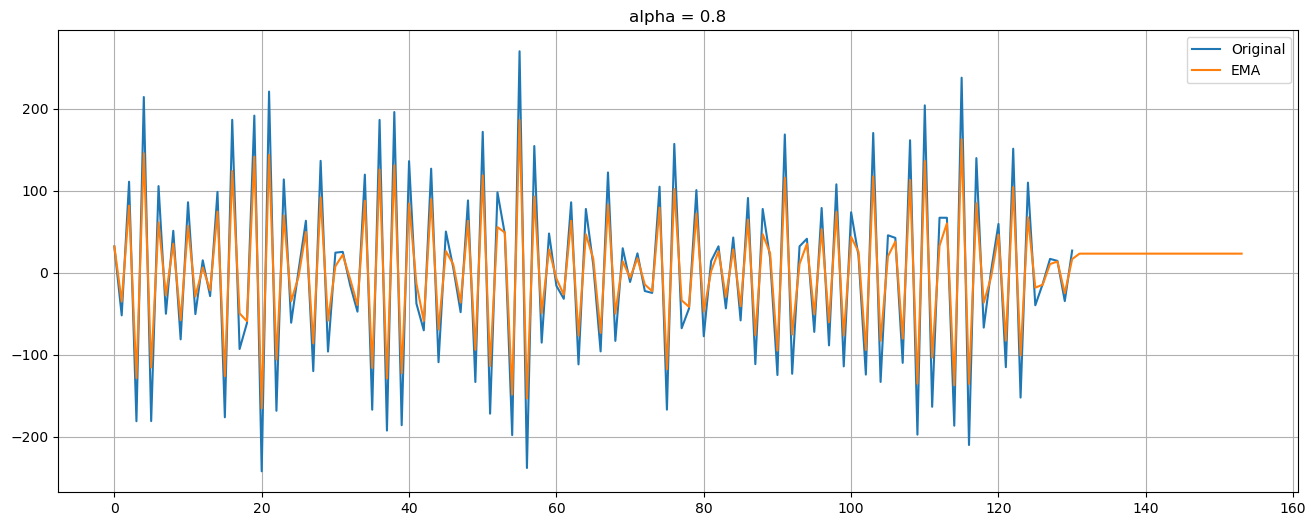

In [15]:
plot_ema(0.8, series, series, 24)

**Для подбора параметра `alpha` воспользуюсь кросс-валидационным подходом**

In [16]:
def mse_cross_val_ema(X):
    alpha = X
    split = TimeSeriesSplit(n_splits=6)
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        
        result = ema_with_preds(train_split_ts, alpha, len(test_split))
        predictions = result[-len(test_split):]
        errors.append(mean_squared_error(predictions, test_split_ts))
        
    return np.mean(np.array(errors))

**Разделю выборку на обучающую и валидационную, оставив для обучения 10 сезонов, а для валидации все, что осталось**

In [17]:
train, val = series[:120], series[120:]

**Для подбора параметра `alpha` оптимизатор будет минимизировать мою функцию потерь `mse_cross_val_ema`**

MSE: 14345.966322035963


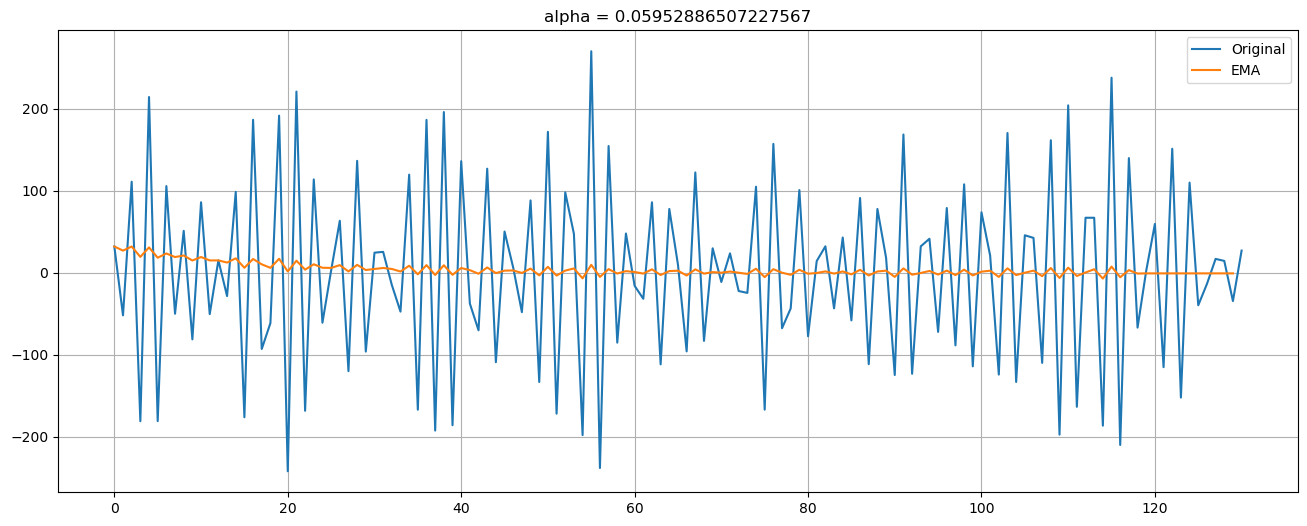

In [18]:
opt = minimize(mse_cross_val_ema, x0=[0], method='L-BFGS-B', bounds=((0, 1),))
alpha_opt = opt.x[0]
plot_ema(alpha_opt, series=train, ser_to_plot=series, n_pred=len(val))
print('MSE:', opt.fun)

**Как видно на графике, оптимизатору не удается минимизировать функцию потерь для предсказаний на стационарном графике. Определенное им значение параметра `alpha` таково, чтобы предсказанные значения находились примерно вокруг среднего, то есть около нуля. На валидационной выборке таким образом предсказание становится просто прямой линией с нулевым уровнем**